## Simple Example of Gaussian Regression 

Consider a simple linear regression problem,

$$
y_i = x_1 + a_i x_2 + \epsilon_i, \quad i = 1,\ldots,m,
$$

where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$.
From our example in lecture, we form the optimization problem to try to obtain the intercept $x_0$ and slope $x_1$.

$$
\min_x~~\frac{1}{2}\|Ax - y\|^2,
$$

where,

$$
y = \begin{bmatrix}
y_1 \\
\vdots \\
y_m
\end{bmatrix}, \quad
A = \begin{bmatrix}
1 & a_1 \\
\vdots & \vdots \\
1 & a_m
\end{bmatrix}, \quad
x = \begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}.
$$

In [44]:
import numpy as np
import matplotlib.pyplot as plt

## Create data

In [61]:
np.random.seed(345)
#
m = 100
n = 2
s1 = 0.5       # variance of inliers
s2 = 20.0      # value of OUTLIER 
#
a = np.linspace(1.0, 5.0, m)
A = np.hstack((np.ones((m,1)), a.reshape(m,1)))
x = np.random.randn(2)
e = s1*np.random.randn(m)
e[-5:-1] += s2
e[1:5]-= s2
#e[-2] += s2
#
y = A.dot(x) + e

Text(0.5, 1.0, 'linear regression data with outliers')

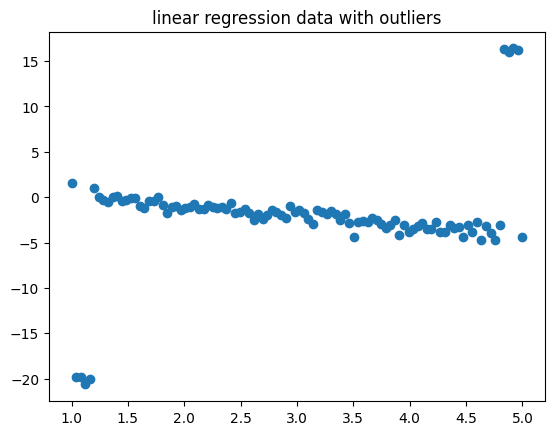

In [62]:
# plot the data
plt.plot(a, y, 'o')
plt.title('linear regression data with outliers')

## Linear regression

Recall that, we have a closed form solution for the linear regression problem,

$$
x^* = (A^\top A)^{-1}(A^\top y)
$$

Let's see how the solution behaves at the presence of outlier.

In [63]:
ATA = A.T.dot(A)
ATy = A.T.dot(y)
#
x_ls = np.linalg.solve(ATA, ATy)
y_ls = A.dot(x_ls)

Text(0.5, 1.0, 'linear regression solution')

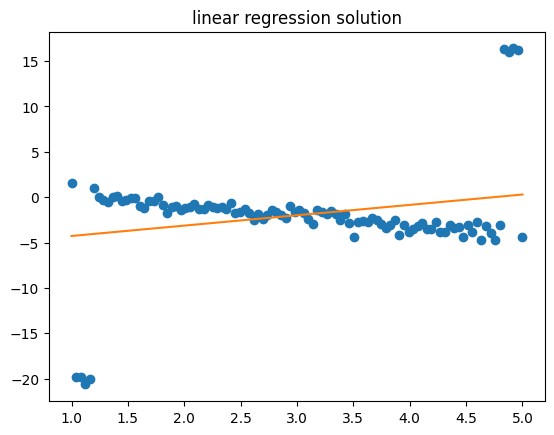

In [64]:
# plot the result
plt.plot(a, y, 'o')
plt.plot(a, y_ls)
plt.title('linear regression solution')

## Student's t penalty

In order to deal with outlier, we introduce [Student's t](https://en.wikipedia.org/wiki/Student%27s_t-distribution) penalty.

$y_i = x_0 + x_1 a_i + \epsilon_i, \quad \epsilon_i \sim St$  


* Negative log of Gaussian density yields least squares: $\frac{1}{2}(y_i - x_0 - x_ia_i)^2$

* Negative log of Student's t density yields log of 1 plus scaled square: $\ln(1 + (y_i - x_0 - x_ia_i)^2/\nu)$

Here we denote $r = A x - y$ as the residual.

And by using Student's t penalty our optimization problem becomes,

$$
\min_x~~F(Ax - y):= \sum_{i=1}^m f(r_i) = \sum_{i=1}^m \ln(1 + r_i^2/\nu), \quad \text{s.t.}~~r = Ax - y.
$$

In [65]:
nu = 1.0
z = np.linspace(-4.5, 4.5, 401)
y_gaussian = 0.5*z**2
y_gaussian_influence = z
y_studentt = np.log(1.0 + z**2/nu)
y_studentt_influence = (2*z/nu)/(1.0 + z**2/nu)

Text(0.5, 1.0, "Gaussian vs Student's t")

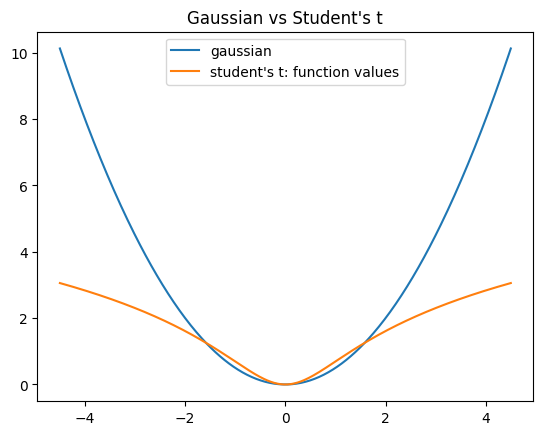

In [66]:
plt.plot(z, y_gaussian)
plt.plot(z, y_studentt)
plt.legend(['gaussian', 'student\'s t: function values'])
plt.title('Gaussian vs Student\'s t')

Text(0.5, 1.0, "Gaussian vs Student's t")

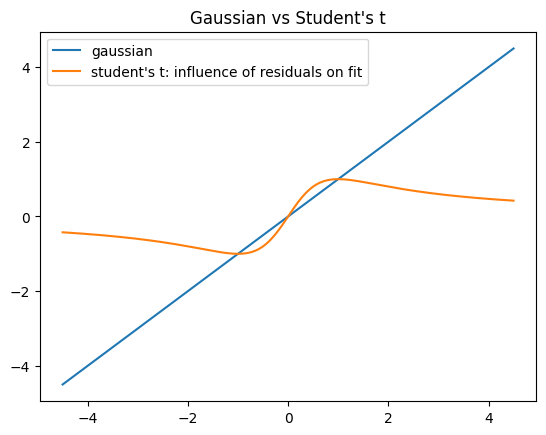

In [67]:
plt.plot(z, y_gaussian_influence)
plt.plot(z, y_studentt_influence)
plt.legend(['gaussian', 'student\'s t: influence of residuals on fit'])
plt.title('Gaussian vs Student\'s t')

## Gradient descent on Student's t regression

To find a simple step size rule, we can compute an upper bound for the Hessian. 

Fortunately, it is $\beta$ smooth, to see this we calculate the gradient and Hessian of the stduent's t function.

$$
f'(r_i) = \frac{2 r_i}{\nu + r_i^2}, \quad f''(r_i) = \frac{2(\nu - r_i^2)}{(\nu + r_i^2)^2}.
$$

And we could see that,
$$
f''(r_i) \le \frac{2}{\nu}.
$$
From the chain rule we have,
$$
\nabla^2 F(Ax - y) = A^\top \nabla^2 F(r) A ~~\Rightarrow~~ \|\nabla^2 F(Ax - y)\| \le \frac{2}{\nu}\|A\|^2.
$$
and we could set $\beta = \frac{2}{\nu}\|A\|^2$.


In [68]:
# define all the functions
def stRFunc(r):
    return np.sum(np.log(1.0 + r**2/nu))
#
def stRGrad(r):
    return 2.0*r/(nu + r**2)
#

def stFunc(x):
    r = A.dot(x) - y
    return stRFunc(r)
#
def stGrad(x):
    r = A.dot(x) - y
    return A.T.dot(stRGrad(r))


In [69]:
# gradient descent
beta = 2.0/nu*np.linalg.norm(A)**2

# initial guess
x_st_gd = np.zeros(n)
g_st_gd = stGrad(x_st_gd)

tol = 1e-12
max_iter = 50000
print_per_iter = 200

err = np.linalg.norm(g_st_gd)
iter_count = 0


while err >= tol:
    # gradient step
    x_st_gd = x_st_gd - 1.0/beta*g_st_gd
    #
    g_st_gd = stGrad(x_st_gd)
    err = np.linalg.norm(g_st_gd)
    obj = stFunc(x_st_gd)
    #
    iter_count += 1
    if iter_count % print_per_iter == 0:
        print('iter %5d, obj %8.2e, err %8.2e' % (iter_count, obj, err))
    #
    if iter_count >= max_iter:
        break

iter   200, obj 6.97e+01, err 7.06e+00
iter   400, obj 6.77e+01, err 2.59e+00
iter   600, obj 6.75e+01, err 9.13e-01
iter   800, obj 6.75e+01, err 3.19e-01
iter  1000, obj 6.74e+01, err 1.11e-01
iter  1200, obj 6.74e+01, err 3.88e-02
iter  1400, obj 6.74e+01, err 1.35e-02
iter  1600, obj 6.74e+01, err 4.71e-03
iter  1800, obj 6.74e+01, err 1.64e-03
iter  2000, obj 6.74e+01, err 5.73e-04
iter  2200, obj 6.74e+01, err 2.00e-04
iter  2400, obj 6.74e+01, err 6.96e-05
iter  2600, obj 6.74e+01, err 2.43e-05
iter  2800, obj 6.74e+01, err 8.46e-06
iter  3000, obj 6.74e+01, err 2.95e-06
iter  3200, obj 6.74e+01, err 1.03e-06
iter  3400, obj 6.74e+01, err 3.59e-07
iter  3600, obj 6.74e+01, err 1.25e-07
iter  3800, obj 6.74e+01, err 4.36e-08
iter  4000, obj 6.74e+01, err 1.52e-08
iter  4200, obj 6.74e+01, err 5.30e-09
iter  4400, obj 6.74e+01, err 1.85e-09
iter  4600, obj 6.74e+01, err 6.44e-10
iter  4800, obj 6.74e+01, err 2.25e-10
iter  5000, obj 6.74e+01, err 7.83e-11
iter  5200, obj 6.74e+01,

## Result comparison

Now let's compare results

In [70]:
y_st = A.dot(x_st_gd)

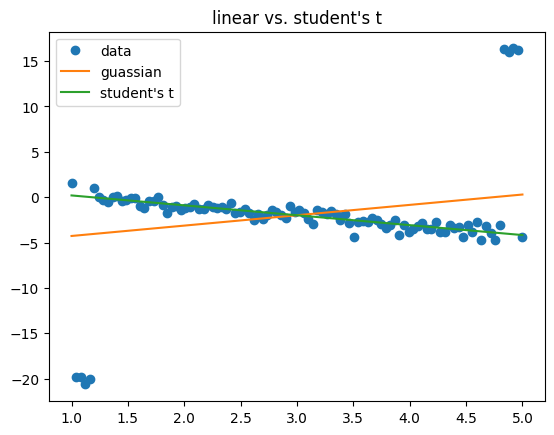

In [73]:
plt.plot(a, y, 'o')
plt.plot(a, y_ls)
plt.plot(a, y_st)
plt.legend(['data','guassian', 'student\'s t'])
plt.title('linear vs. student\'s t')
plt.savefig('robust_reg.pdf')

<Figure size 640x480 with 0 Axes>